In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from tqdm.notebook import tqdm

import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from src.signal_categories import topological_category_labels, topological_category_colors
from src.signal_categories import physics_category_labels, physics_category_colors
from src.signal_categories import filetype_category_labels, filetype_category_colors

from src.file_locations import intermediate_files_location


# File Loading

In [2]:
training = "first_combined_training"
#training = "first_wc_training"
#training = "first_lantern_training"

In [3]:
print("loading all_df.pkl...")
with open(f"{intermediate_files_location}/all_df.pkl", "rb") as f:
    all_df = pickle.load(f)
print(f"{all_df.shape=}")

# this only includes predictions for events passing the preselection used during training
print("loading predictions.pkl...")
with open(f"../training_outputs/{training}/predictions.pkl", "rb") as f:
    pred_df = pickle.load(f)
print(f"{pred_df.shape=}")

print("merging all_df and predictions.pkl...")
merged_df = pd.merge(all_df, pred_df, on=["filetype", "run", "subrun", "event"], how="left")

sig_categories = topological_category_labels

prob_categories = ["prob_" + cat for cat in sig_categories]

for prob in prob_categories:
    merged_df[prob] = merged_df[prob].fillna(-1)


num_train_events = len(merged_df.query("used_for_training == True"))
num_test_events = len(merged_df.query("used_for_testing == True"))
print(f"{len(merged_df)=}")
print(f"{num_train_events=}")
print(f"{num_test_events=}")

frac_test = num_test_events / (num_train_events + num_test_events)
print(f"weighting up by the fraction of test events: {frac_test:.3f}")

modified_net_weights = []
used_for_testing = merged_df["used_for_testing"].to_numpy()
wc_net_weights = merged_df["wc_net_weight"].to_numpy()
for i in range(len(merged_df)):
    if used_for_testing[i]:
        modified_net_weights.append(wc_net_weights[i] / frac_test)
    else:
        modified_net_weights.append(wc_net_weights[i])
merged_df["wc_net_weight"] = modified_net_weights         

merged_df = merged_df.query("used_for_testing == True or not (used_for_testing == used_for_testing)") # include nans here as well, events which didn't pass pre-selection
generic_merged_df = merged_df.query("wc_kine_reco_Enu > 0")
presel_merged_df = generic_merged_df.query("wc_shw_sp_n_20mev_showers > 0")

print(f"{merged_df.shape=}")
print(f"{generic_merged_df.shape=}")
print(f"{presel_merged_df.shape=}")


loading all_df.pkl...
all_df.shape=(2171921, 200)
loading predictions.pkl...
pred_df.shape=(356805, 22)
merging all_df and predictions.pkl...
len(merged_df)=2171921
num_train_events=178402
num_test_events=178403
weighting up by the fraction of test events: 0.500
merged_df.shape=(1993519, 218)
generic_merged_df.shape=(311471, 218)
presel_merged_df.shape=(178403, 218)


In [4]:
probs_2d_arr = presel_merged_df[prob_categories].to_numpy()
reco_categories_argmax = np.argmax(probs_2d_arr, axis=1)
presel_merged_df["reco_category_argmax_index"] = reco_categories_argmax


/tmp/ipykernel_2406082/3461509963.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  presel_merged_df["reco_category_argmax_index"] = reco_categories_argmax


# Preselection Efficiencies

In [5]:
breakdown_queries = []
for label in topological_category_labels:
    breakdown_queries.append(f"topological_signal_category == '{label}'")

total_num_truth_by_category = [np.sum(merged_df.query(query)["wc_net_weight"]) for query in breakdown_queries]
total_num_generic_truth_by_category = [np.sum(generic_merged_df.query(query)["wc_net_weight"]) for query in breakdown_queries]
total_num_presel_truth_by_category = [np.sum(presel_merged_df.query(query)["wc_net_weight"]) for query in breakdown_queries]

print("WC Generic Selection Topological Efficiencies:")
for i in range(len(topological_category_labels)):
    print(f"{topological_category_labels[i]}: {total_num_generic_truth_by_category[i]} / {total_num_truth_by_category[i]} = {total_num_generic_truth_by_category[i] / total_num_truth_by_category[i]:.3f}")

print("\nPreselection Topological Efficiencies:")
for i in range(len(topological_category_labels)):
    print(f"{topological_category_labels[i]}: {total_num_presel_truth_by_category[i]} / {total_num_truth_by_category[i]} = {total_num_presel_truth_by_category[i] / total_num_truth_by_category[i]:.3f}")


WC Generic Selection Topological Efficiencies:
1gNp: 1258.1912235557038 / 2442.226642456372 = 0.515
1g0p: 603.8846021208074 / 1643.0540118075605 = 0.368
1gNp1mu: 3724.2731921095155 / 5528.631112376388 = 0.674
1g0p1mu: 673.7163723944499 / 1073.4335581089433 = 0.628
1g_outFV: 3949.3096244555873 / 19594.636250048155 = 0.202
2gNp: 8614.394425331784 / 12322.961859711617 = 0.699
2g0p: 5151.005535700824 / 8403.663377221097 = 0.613
2gNp1mu: 23535.16198620421 / 29345.557392930863 = 0.802
2g0p1mu: 4400.869872329602 / 5740.370359105014 = 0.767
2g_outFV: 2745.6403663922774 / 8459.676229124192 = 0.325
1eNp: 1587.6439085085435 / 1978.133067430229 = 0.803
1e0p: 346.6399601529836 / 474.57572520643123 = 0.730
0g: 440475.0689171847 / 1744842.1813996949 = 0.252
3plusg: 6029.097080683112 / 7975.662568048147 = 0.756
dirt: 21697.449952327042 / 799562.6691933963 = 0.027
ext: 73821.60290347115 / 6438209.09598104 = 0.011

Preselection Topological Efficiencies:
1gNp: 883.3623688287913 / 2442.226642456372 = 0.36

In [6]:
total_num_truth_by_category

[np.float64(2442.226642456372),
 np.float64(1643.0540118075605),
 np.float64(5528.631112376388),
 np.float64(1073.4335581089433),
 np.float64(19594.636250048155),
 np.float64(12322.961859711617),
 np.float64(8403.663377221097),
 np.float64(29345.557392930863),
 np.float64(5740.370359105014),
 np.float64(8459.676229124192),
 np.float64(1978.133067430229),
 np.float64(474.57572520643123),
 np.float64(1744842.1813996949),
 np.float64(7975.662568048147),
 np.float64(799562.6691933963),
 np.float64(6438209.09598104)]

In [7]:
total_num_presel_truth_by_category

[np.float64(883.3623688287913),
 np.float64(494.3439561289009),
 np.float64(2727.098863101781),
 np.float64(475.5524237364367),
 np.float64(3173.242897006535),
 np.float64(7417.412834592929),
 np.float64(4643.528692564616),
 np.float64(20086.46590586726),
 np.float64(3665.1964360543275),
 np.float64(2221.8154468389084),
 np.float64(1436.2781695271033),
 np.float64(321.61202868395156),
 np.float64(100062.99783495768),
 np.float64(5650.674079895185),
 np.float64(6422.291618278848),
 np.float64(28721.62654080553)]

# Argmax Efficiencies

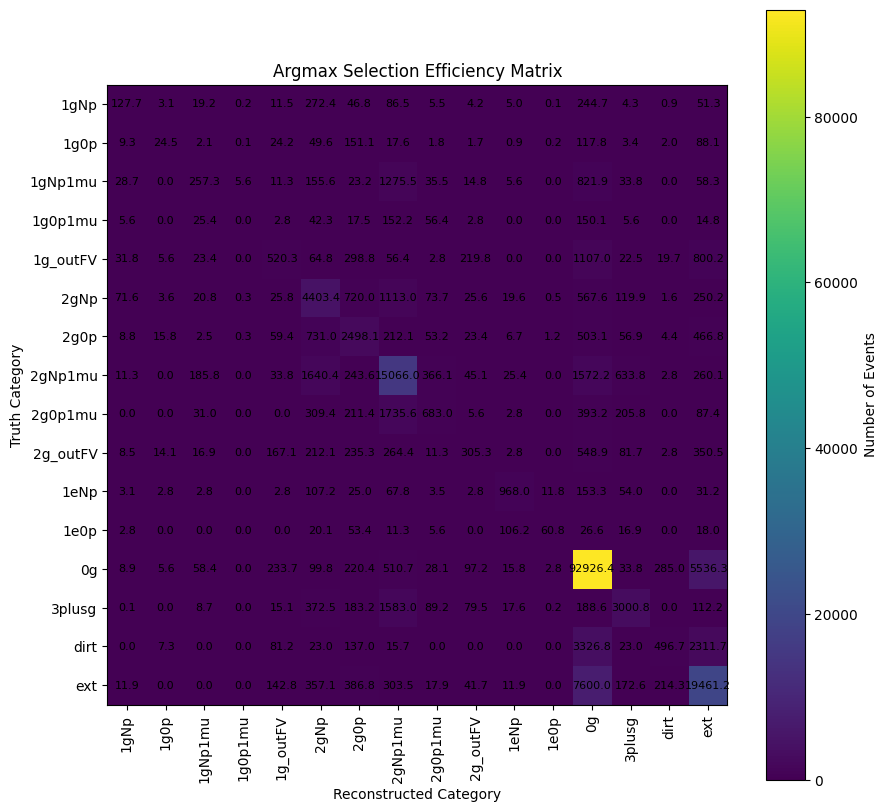

In [8]:
argmax_sel_matrix = np.zeros((len(topological_category_labels), len(topological_category_labels)))
for i in range(len(topological_category_labels)):
    for j in range(len(topological_category_labels)):
        argmax_sel_matrix[i, j] = presel_merged_df.query(f"topological_signal_category == '{topological_category_labels[i]}' and reco_category_argmax_index == {j}")["wc_net_weight"].sum()

plt.figure(figsize=(10, 10))
plt.imshow(argmax_sel_matrix)
plt.colorbar(label="Number of Events")
for i in range(len(topological_category_labels)):
    for j in range(len(topological_category_labels)):
        plt.text(j, i, f'{argmax_sel_matrix[i,j]:.1f}', ha='center', va='center', fontsize=8)
plt.xticks(range(len(topological_category_labels)), topological_category_labels, rotation=90)
plt.yticks(range(len(topological_category_labels)), topological_category_labels)
plt.xlabel("Reconstructed Category")
plt.ylabel("Truth Category")
plt.title("Argmax Selection Efficiency Matrix")
plt.show()


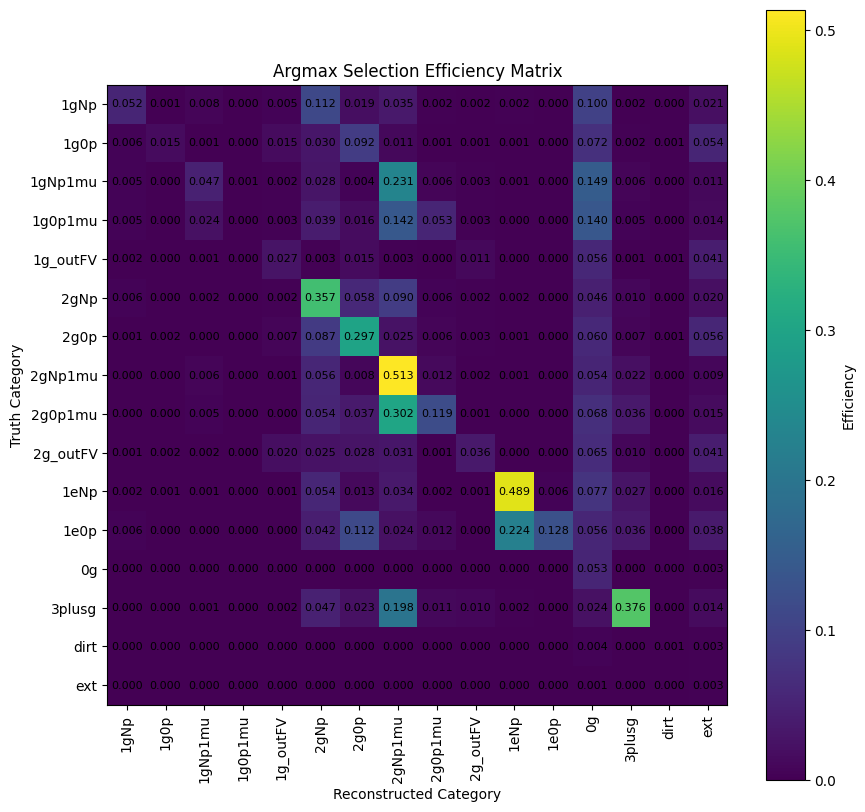

In [9]:
argmax_eff_matrix = (argmax_sel_matrix.T / total_num_truth_by_category).T

plt.figure(figsize=(10, 10))
plt.imshow(argmax_eff_matrix)
plt.colorbar(label="Efficiency")
for i in range(len(topological_category_labels)):
    for j in range(len(topological_category_labels)):
        plt.text(j, i, f'{argmax_eff_matrix[i,j]:.3f}', ha='center', va='center', fontsize=8)
plt.xticks(range(len(topological_category_labels)), topological_category_labels, rotation=90)
plt.yticks(range(len(topological_category_labels)), topological_category_labels)
plt.xlabel("Reconstructed Category")
plt.ylabel("Truth Category")
plt.title("Argmax Selection Efficiency Matrix")
plt.show()

# 1g Efficiencies By Cut Value

In [10]:
merged_df["prob_1g_combined"] = (merged_df["prob_1gNp"] 
                                      + merged_df["prob_1g0p"]
                                      + merged_df["prob_1gNp1mu"]
                                      + merged_df["prob_1g0p1mu"]
                                      + merged_df["prob_1g_outFV"])

merged_df.loc[merged_df["wc_kine_reco_Enu"] < 0, "wc_nc_delta_score_generic"] = -999
merged_df.loc[merged_df["wc_nc_delta_score_generic"].isna(), "wc_nc_delta_score_generic"] = -999


In [11]:
merged_df["wc_truth_muonMomentum"].to_numpy()

array([list([-1.0, -1.0, -1.0, -1.0]), list([-1.0, -1.0, -1.0, -1.0]),
       list([-1.0, -1.0, -1.0, -1.0]), ...,
       list([-1.0, -1.0, -1.0, -1.0]), list([-1.0, -1.0, -1.0, -1.0]),
       list([-1.0, -1.0, -1.0, -1.0])], dtype=object)

In [12]:
merged_df["wc_truth_muonMomentum_3"] = [-1 if isinstance(x, float) else x[3] for x in merged_df["wc_truth_muonMomentum"].to_numpy()]

#erin_sig_query = "(wc_match_completeness_energy>0.1*wc_truth_energyInside and wc_truth_single_photon==1 and (wc_truth_isCC==0 or (wc_truth_isCC==1 and abs(wc_truth_nuPdg)==14 and abs(wc_truth_muonMomentum_3-0.105658)<0.1)))"
erin_sig_query = "(wc_truth_single_photon==1 and (wc_truth_isCC==0 or (wc_truth_isCC==1 and abs(wc_truth_nuPdg)==14 and abs(wc_truth_muonMomentum_3-0.105658)<0.1)))"
merged_df["erin_inclusive_1g_true_sig"] = merged_df.eval(erin_sig_query).astype(int)

wc_inclusive_selected_flag = []
shw_sp_n_20mev_showers_vals = merged_df["wc_shw_sp_n_20mev_showers"].to_numpy()
reco_nuvtxX_vals = merged_df["wc_reco_nuvtxX"].to_numpy()
reco_nuvtxY_vals = merged_df["wc_reco_nuvtxY"].to_numpy()
reco_nuvtxZ_vals = merged_df["wc_reco_nuvtxZ"].to_numpy()
single_photon_numu_score_vals = merged_df["wc_single_photon_numu_score"].to_numpy()
single_photon_other_score_vals = merged_df["wc_single_photon_other_score"].to_numpy()
single_photon_ncpi0_score_vals = merged_df["wc_single_photon_ncpi0_score"].to_numpy()
single_photon_nue_score_vals = merged_df["wc_single_photon_nue_score"].to_numpy()
shw_sp_n_20br1_showers_vals = merged_df["wc_shw_sp_n_20br1_showers"].to_numpy()
for i in tqdm(range(len(merged_df))):
    if (shw_sp_n_20mev_showers_vals[i] > 0
         and reco_nuvtxX_vals[i] > 5.0 and reco_nuvtxX_vals[i] < 250.0
           and single_photon_numu_score_vals[i] > 0.4 and single_photon_other_score_vals[i] > 0.2
             and single_photon_ncpi0_score_vals[i] > -0.05 and single_photon_nue_score_vals[i] > -1.0
               and shw_sp_n_20br1_showers_vals[i] == 1):
        wc_inclusive_selected_flag.append(1)
    else:
        wc_inclusive_selected_flag.append(0)
merged_df["erin_inclusive_1g_sel"] = wc_inclusive_selected_flag


  0%|          | 0/1993519 [00:00<?, ?it/s]

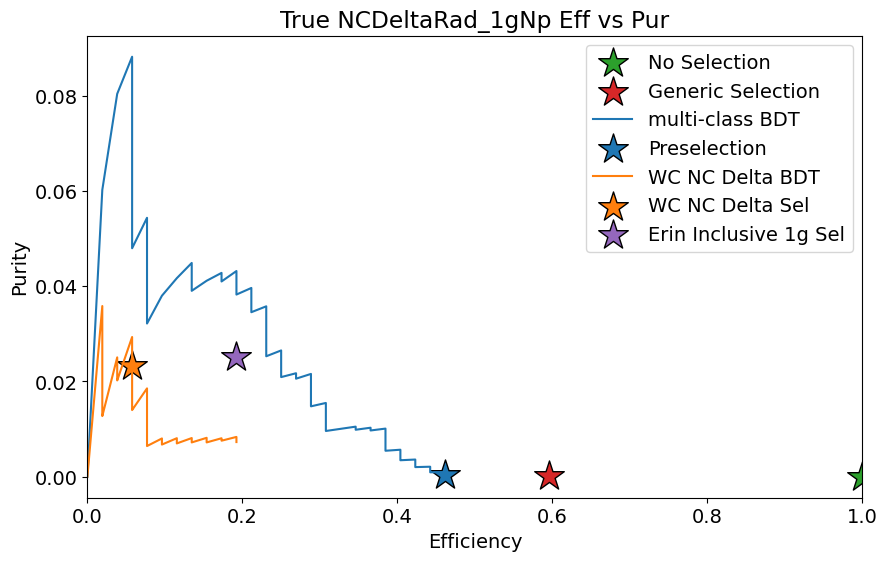

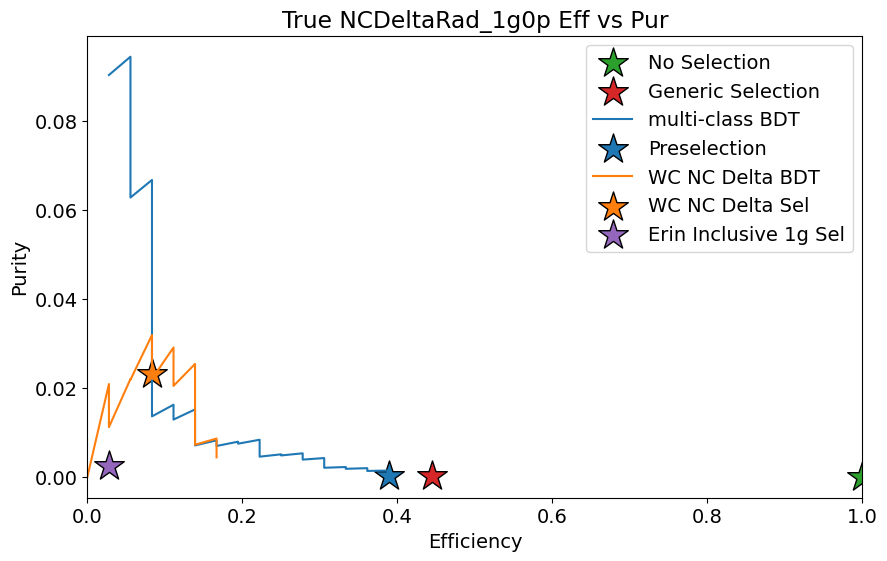

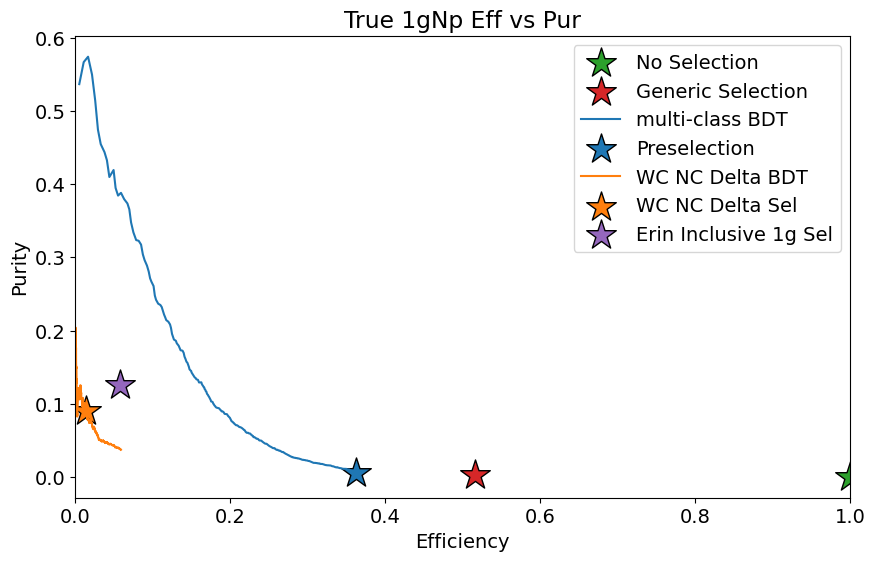

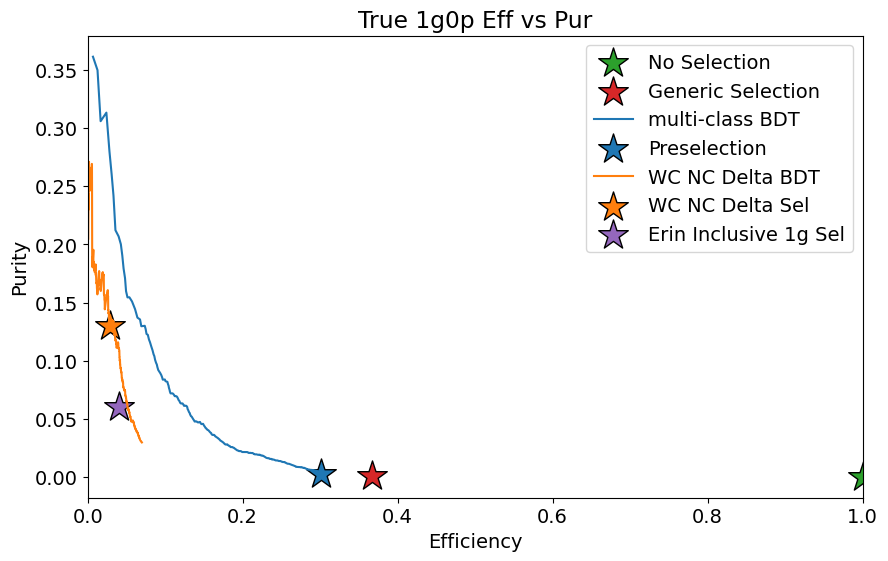

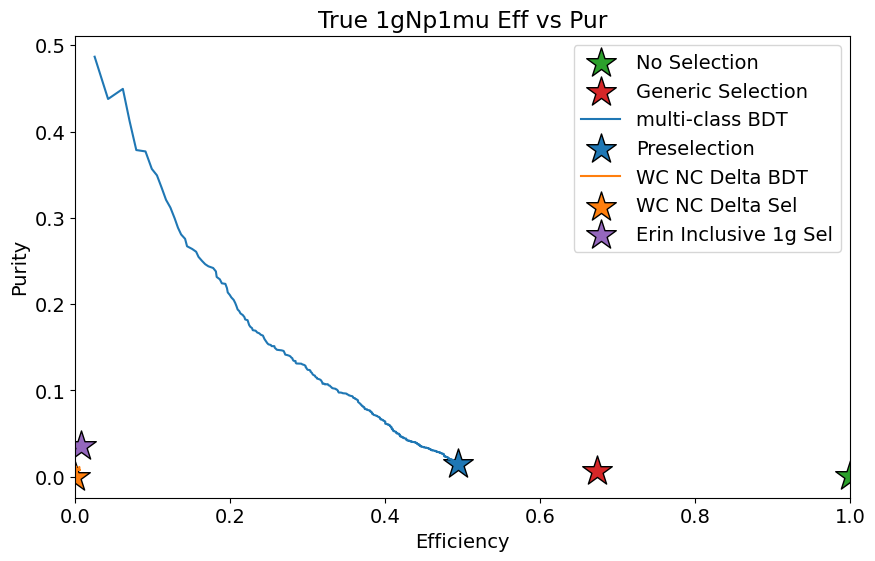

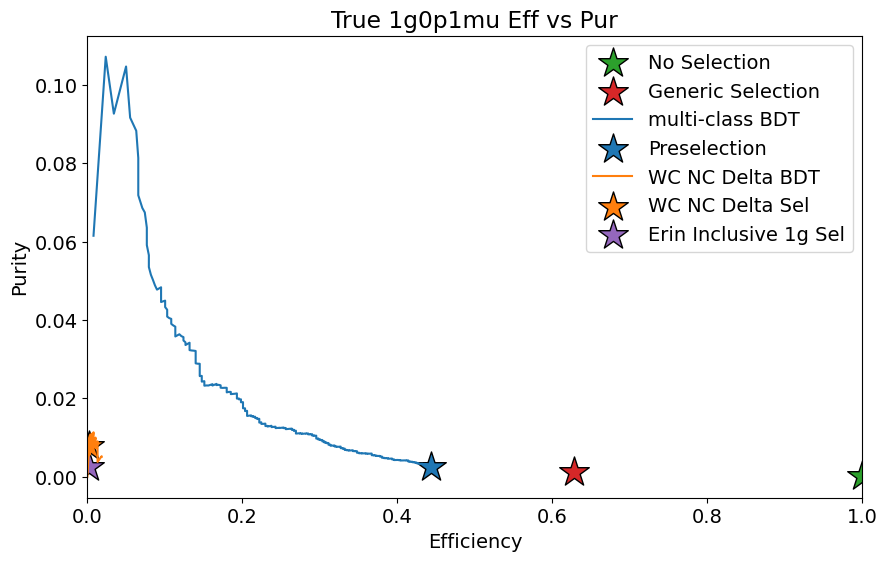

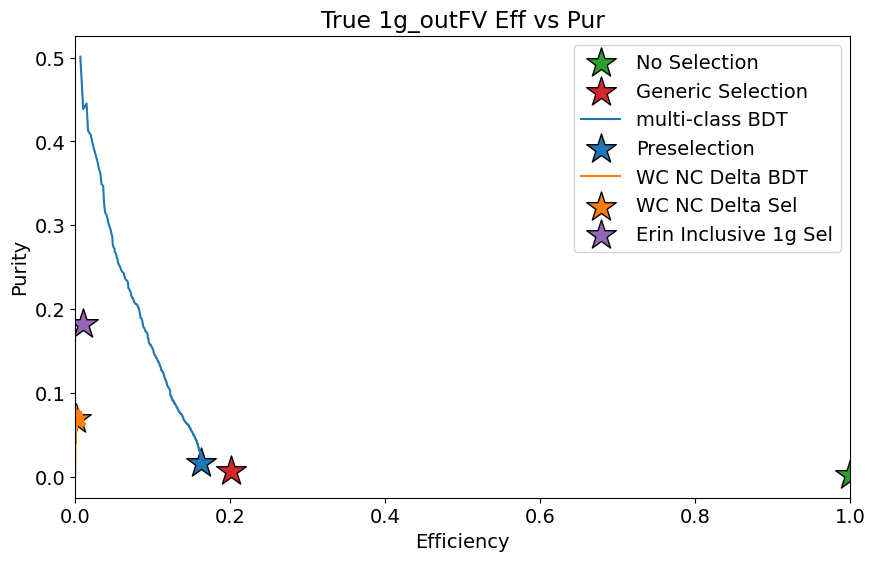

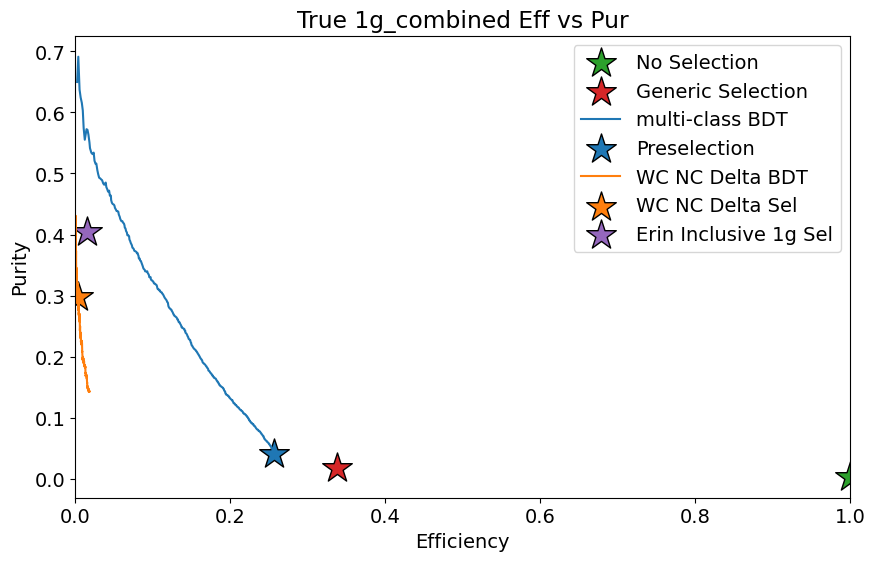

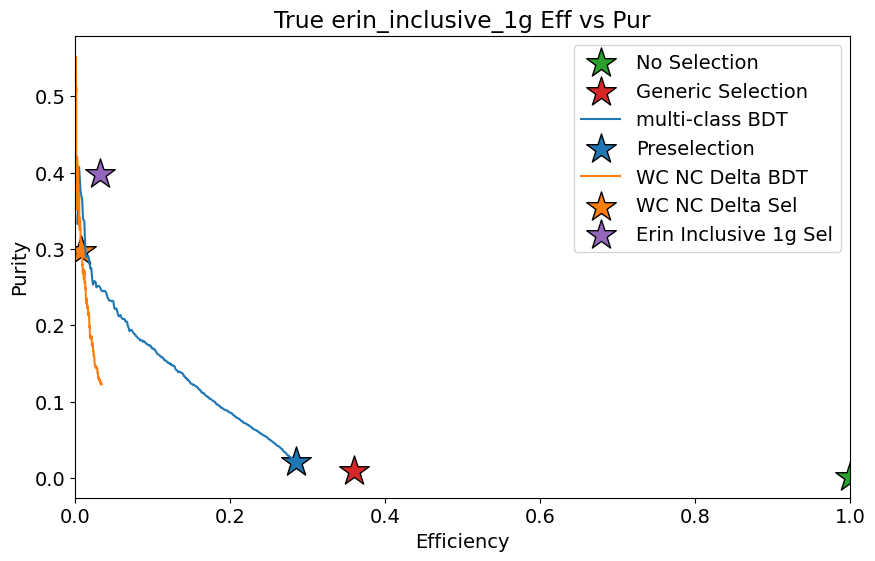

In [13]:
# for each 1g category, as well as combined 1g categories:
# eff vs pur as function of cut value
# compare with NC Delta selection curve
# compare with Erin inclusive 1g curve and point
# maybe ask Mark about including the gLEE point? Might be totally different with nugraph...

plt.rcParams.update({'font.size': 14})

for one_g_cat in ["NCDeltaRad_1gNp", "NCDeltaRad_1g0p", "1gNp", "1g0p", "1gNp1mu", "1g0p1mu", "1g_outFV", "1g_combined", "erin_inclusive_1g"]:

    if one_g_cat == "1g_combined":

        sig_df = merged_df.query(f"""
           topological_signal_category == '1gNp'
        or topological_signal_category == '1g0p'
        or topological_signal_category == '1gNp1mu'
        or topological_signal_category == '1g0p1mu'
        or topological_signal_category == '1g_outFV'
        """.strip().replace("\n", ""))
        bkg_df = merged_df.query(f"""
            topological_signal_category != '1gNp'
        and topological_signal_category != '1g0p'
        and topological_signal_category != '1gNp1mu'
        and topological_signal_category != '1g0p1mu'
        and topological_signal_category != '1g_outFV'
        """.strip().replace("\n", ""))

        total_sig = np.sum(sig_df["wc_net_weight"])

    elif one_g_cat == "erin_inclusive_1g":
        sig_df = merged_df.query(f"erin_inclusive_1g_true_sig == 1")
        bkg_df = merged_df.query(f"erin_inclusive_1g_true_sig == 0")
        total_sig = np.sum(sig_df["wc_net_weight"])

    elif one_g_cat == "NCDeltaRad_1gNp":
        sig_df = merged_df.query(f"physics_signal_category == 'NCDeltaRad_1gNp'")
        bkg_df = merged_df.query(f"physics_signal_category != 'NCDeltaRad_1gNp'")
        total_sig = np.sum(sig_df["wc_net_weight"])

    elif one_g_cat == "NCDeltaRad_1g0p":
        sig_df = merged_df.query(f"physics_signal_category == 'NCDeltaRad_1g0p'")
        bkg_df = merged_df.query(f"physics_signal_category != 'NCDeltaRad_1g0p'")
        total_sig = np.sum(sig_df["wc_net_weight"])

    else:
        sig_df = merged_df.query(f"topological_signal_category == '{one_g_cat}'")
        bkg_df = merged_df.query(f"topological_signal_category != '{one_g_cat}'")
        total_sig = np.sum(sig_df["wc_net_weight"])

    multi_class_bdt_score_name = f"prob_{one_g_cat}"
    if one_g_cat == "erin_inclusive_1g":
        multi_class_bdt_score_name = "prob_1g_combined"
    if one_g_cat == "NCDeltaRad_1gNp":
        multi_class_bdt_score_name = "prob_1gNp"
    if one_g_cat == "NCDeltaRad_1g0p":
        multi_class_bdt_score_name = "prob_1g0p"

    sig_bdt_scores = sig_df[multi_class_bdt_score_name].to_numpy()
    bkg_bdt_scores = bkg_df[multi_class_bdt_score_name].to_numpy()
    sig_weights = sig_df["wc_net_weight"].to_numpy()
    bkg_weights = bkg_df["wc_net_weight"].to_numpy()

    all_bdt_scores = np.concatenate([sig_bdt_scores, bkg_bdt_scores])
    good_bdt_scores = all_bdt_scores[all_bdt_scores >= 0]
    num_points = 1000
    cutoffs = np.quantile(good_bdt_scores, np.linspace(0, 1, num_points))
    cutoffs = np.concatenate([[0], cutoffs, [1]])
    all_effs = []
    all_purs = []
    for cutoff in cutoffs:
        sig_sel_weights = sig_weights[sig_bdt_scores > cutoff]
        sig_sel = np.sum(sig_sel_weights)
        sig_sel_err = np.sqrt(np.sum(sig_sel_weights**2))
        bkg_sel_weights = bkg_weights[bkg_bdt_scores > cutoff]
        bkg_sel = np.sum(bkg_sel_weights)
        bkg_sel_err = np.sqrt(np.sum(bkg_sel_weights**2))
        eff = sig_sel / total_sig if total_sig > 0 else np.nan
        pur = sig_sel / (sig_sel + bkg_sel) if sig_sel + bkg_sel > 0 else np.nan
        all_effs.append(eff)
        all_purs.append(pur)
        #print(f"{cutoff=}, {sig_sel=}, {bkg_sel=}, {eff=}, {pur=}")

    sig_nc_delta_bdt_scores = sig_df["wc_nc_delta_score"].to_numpy()
    bkg_nc_delta_bdt_scores = bkg_df["wc_nc_delta_score"].to_numpy()
    all_nc_delta_bdt_scores = np.concatenate([sig_nc_delta_bdt_scores, bkg_nc_delta_bdt_scores])
    good_nc_delta_bdt_scores = all_nc_delta_bdt_scores[all_nc_delta_bdt_scores >= 0]
    cutoffs = np.quantile(good_nc_delta_bdt_scores, np.linspace(0, 1, num_points))
    all_effs_nc_delta = []
    all_purs_nc_delta = []
    for cutoff in cutoffs:
        sig_sel_weights = sig_weights[sig_nc_delta_bdt_scores > cutoff]
        sig_sel = np.sum(sig_sel_weights)
        sig_sel_err = np.sqrt(np.sum(sig_sel_weights**2))
        bkg_sel_weights = bkg_weights[bkg_nc_delta_bdt_scores > cutoff]
        bkg_sel = np.sum(bkg_sel_weights)
        bkg_sel_err = np.sqrt(np.sum(bkg_sel_weights**2))
        eff = sig_sel / total_sig if total_sig > 0 else np.nan
        pur = sig_sel / (sig_sel + bkg_sel) if sig_sel + bkg_sel > 0 else np.nan
        all_effs_nc_delta.append(eff)
        all_purs_nc_delta.append(pur)

    nc_delta_261_sig_sel_weights = sig_df.query("wc_nc_delta_score > 2.61")["wc_net_weight"].to_numpy()
    nc_delta_261_sig_sel = np.sum(nc_delta_261_sig_sel_weights)
    nc_delta_261_bkg_sel_weights = bkg_df.query("wc_nc_delta_score > 2.61")["wc_net_weight"].to_numpy()
    nc_delta_261_bkg_sel = np.sum(nc_delta_261_bkg_sel_weights)
    nc_delta_261_eff = nc_delta_261_sig_sel / total_sig if total_sig > 0 else np.nan
    nc_delta_261_pur = nc_delta_261_sig_sel / (nc_delta_261_sig_sel + nc_delta_261_bkg_sel) if nc_delta_261_sig_sel + nc_delta_261_bkg_sel > 0 else np.nan

    erin_inclusive_1g_sig_sel_weights = sig_df.query("erin_inclusive_1g_sel == 1")["wc_net_weight"].to_numpy()
    erin_inclusive_1g_sig_sel = np.sum(erin_inclusive_1g_sig_sel_weights)
    erin_inclusive_1g_bkg_sel_weights = bkg_df.query("erin_inclusive_1g_sel == 1")["wc_net_weight"].to_numpy()
    erin_inclusive_1g_bkg_sel = np.sum(erin_inclusive_1g_bkg_sel_weights)
    erin_inclusive_1g_eff = erin_inclusive_1g_sig_sel / total_sig if total_sig > 0 else np.nan
    erin_inclusive_1g_pur = erin_inclusive_1g_sig_sel / (erin_inclusive_1g_sig_sel + erin_inclusive_1g_bkg_sel) if erin_inclusive_1g_sig_sel + erin_inclusive_1g_bkg_sel > 0 else np.nan

    nosel_sig_sel = np.sum(sig_df["wc_net_weight"])
    nosel_bkg_sel = np.sum(bkg_df["wc_net_weight"])
    nosel_eff = nosel_sig_sel / total_sig if total_sig > 0 else np.nan
    nosel_pur = nosel_sig_sel / (nosel_sig_sel + nosel_bkg_sel) if nosel_sig_sel + nosel_bkg_sel > 0 else np.nan

    generic_sig_sel_df = sig_df.query("wc_kine_reco_Enu > 0")
    generic_sig_sel = np.sum(generic_sig_sel_df["wc_net_weight"])
    generic_bkg_sel_df = bkg_df.query("wc_kine_reco_Enu > 0")
    generic_bkg_sel = np.sum(generic_bkg_sel_df["wc_net_weight"])
    generic_eff = generic_sig_sel / total_sig if total_sig > 0 else np.nan
    generic_pur = generic_sig_sel / (generic_sig_sel + generic_bkg_sel) if generic_sig_sel + generic_bkg_sel > 0 else np.nan

    presel_sig_sel_df = generic_sig_sel_df.query("wc_shw_sp_n_20mev_showers > 0")
    presel_sig_sel = np.sum(presel_sig_sel_df["wc_net_weight"])
    presel_bkg_sel_df = generic_bkg_sel_df.query("wc_shw_sp_n_20mev_showers > 0")
    presel_bkg_sel = np.sum(presel_bkg_sel_df["wc_net_weight"])
    presel_eff = presel_sig_sel / total_sig if total_sig > 0 else np.nan
    presel_pur = presel_sig_sel / (presel_sig_sel + presel_bkg_sel) if presel_sig_sel + presel_bkg_sel > 0 else np.nan
    

    plt.figure(figsize=(10, 6))

    plt.scatter(nosel_eff, nosel_pur, label="No Selection", marker="*", edgecolor="black", color="tab:green", s=500)
    plt.scatter(generic_eff, generic_pur, label="Generic Selection", marker="*", edgecolors="black", color="tab:red", s=500)

    plt.plot(all_effs, all_purs, color="tab:blue", label="multi-class BDT")
    plt.scatter(presel_eff, presel_pur, label="Preselection", marker="*", edgecolors="black", color="tab:blue", s=500)

    plt.plot(all_effs_nc_delta, all_purs_nc_delta, color="tab:orange", label="WC NC Delta BDT")
    plt.scatter(nc_delta_261_eff, nc_delta_261_pur, label="WC NC Delta Sel", marker="*", edgecolors="black", color="tab:orange", s=500)

    plt.scatter(erin_inclusive_1g_eff, erin_inclusive_1g_pur, label="Erin Inclusive 1g Sel", marker="*", edgecolors="black", color="tab:purple", s=500)

    plt.xlabel("Efficiency")
    plt.ylabel("Purity")
    plt.title(f"True {one_g_cat} Eff vs Pur")
    plt.xlim(0, 1)
    plt.legend(loc="upper right")
    plt.show()
        
